# RNN Model Train Step
Training and evaluation stage of the RNN model, and then we save the model and its respective trained weights.

In this step we perform:
* Model definition;
* Model training;
* Model evaluation;
* Saving the model and trained weights;
* Visualization of word embeddings trained by the model.

## Table of Contents
* [Packages](#1)
* [Loading the Data](#2)
* [Hyperparameters Tuning](#3)
* [RNN Model](#4)
    * [Word Embeddings](#4.1)
    * [LSTM Layer](#4.2)
* [Bidirectional LSTM Model Train](#5)
    * [Model Architecture](#5.1)
* [Word Embeddings VIsualization](#6)

<a name="1"></a>
## Packages
Packages that were used in the system:
* [numpy](www.numpy.org): is the main package for scientific computing;
* [pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure;
* [tensorflow](https://www.tensorflow.org/): framework that makes it easy to create ML models that can run in any environment;
* [skopt](https://scikit-optimize.github.io/stable/): is a simple and efficient library to minimize (very) expensive and noisy functions;
* [scikit-learn](https://scikit-learn.org/stable/): open source machine learning library;
* [matplotlib](http://matplotlib.org): is a library to plot graphs;
* [os](https://docs.python.org/3/library/os.html): built-in module, provides a portable way of using operating system dependent functionality;
* [sys](https://docs.python.org/3/library/sys.html): provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter;
* [src](../src/): package with all the codes for all utility functions created for this system. Located inside the `../../src/` directory.

In [668]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skopt import gp_minimize

import os
import sys
PROJECT_ROOT = os.path.abspath( # Getting Obtaining the absolute normalized version of the project root path
    os.path.join( # Concatenating the paths
        os.getcwd(), # Getting the path of the notebooks directory
        os.pardir, # Gettin the constant string used by the OS to refer to the parent directory
        os.pardir
    )
)
# Adding path to the list of strings that specify the search path for modules
sys.path.append(PROJECT_ROOT)
from src.rnn_model_train import *

> **Note**: the codes for the utility functions used in this system are in the `rnn_model_train.py` script within the `../../src/` directory.

<a name="2"></a>
## Loading the Data
We will read each subset from disk, define the global variables for creating the dataset and model, and we will create the `tensorflow.data.Dataset` for each subset.

Reading each of the subsets from the `../../data/preprocessed/` directory and plotting their dimensions.

In [10]:
# Subset names
files = ['train', 'validation', 'test']
datasets = []
# Looping through each name
for file in files:
    # Reading each subset and adding it to the list for later extraction
    with open(f'../../data/preprocessed/{file}_tokens.npy', 'rb') as f:
        datasets.append(np.load(f))

# Extracting each subset from the `datasets` list
train_corpus, val_corpus, test_corpus = datasets
print(f'Train set shape: {train_corpus.shape}\nValidation set shape: {val_corpus.shape}\nTest set shape: {test_corpus.shape}')

Train set shape: (9682, 167)
Validation set shape: (3227, 167)
Test set shape: (3228, 167)


Setting global variables to create `tensorflow.data.Dataset` and global variables to create the model.

In [700]:
# Dataset global variables
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Model global variables
tokenizer = pickle.load(open('../../models/vectorizer.pkl', 'rb'))
MAX_LEN = tokenizer['config']['output_sequence_length']
EMBEDDING_DIM = 16
DROPOUT_RATE = [.5, .5]
LR = 5e-3
VOCABULARY = tokenizer['vocabulary'] # Loading vocabulary from trained tokenizer
VOCAB_SIZE = len(VOCABULARY)
COLORS = ['cornflowerblue', 'chocolate']
print(f'Vocabulary size: {VOCAB_SIZE}\nMax length: {MAX_LEN}')

Vocabulary size: 1000
Max length: 166


Creating `tensorflow.data.Dataset` for each subset and plotting the training set dimension.

In [14]:
train_set = create_batch_dataset(train_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)
val_set = create_batch_dataset(val_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)
test_set = create_batch_dataset(test_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)

train_batch = next(train_set.as_numpy_iterator())
print(f"Shape of the train batch: {train_batch[0].shape}")

Shape of the train batch: (32, 166)


<a name="3"></a>
## Hyperparameters Tuning
The method used to search for the best hyperparameters for the model was `Bayesian optimization`.

Computing Bayesian Optimization.

In [6]:
# Setting the range for testing learning rate
space = [
    (1e-4, 1e-1, 'log-uniform') # learning rate
]

# Performing Bayesian optimization
#opt = gp_minimize(hyperparams_tune, space, random_state=42, verbose=0, n_calls=5, n_random_starts=2)
# Best hyperparameter
#LR = opt.x
# Output with the best hyperparameter
#print(f'Learning rate: {LR:.4f}')

<a name="4"></a>
## RNN Model
We can try using a standard neural network for this task, or maybe even logistic regression, or Naive Bayes, but these models don't perform well for NLP tasks, and the main problems are:
* Inputs and outputs may have different lengths in different examples. Generally, we fill all inputs to a maximum length, but this still doesn't seem like a good representation.
* Does not share features learned between different positions (time steps $t$) of texts. We like effects similar to CNNs for sequential data, where we want things learned for one part of the image to quickly generalize to other parts of the image.
    * If the standard neural network, with the value "Iron Man" for input unit 1 (time step 1), analyzes that this is part of a person's name, then, wouldn't it be good if we discovered that "Iron Man" appearing in another input unit (time step $t \neq 1$), this also means that this could be a person's name.
* The FC (Dense) layer will have a huge number of parameters. As with ConvNets, using a good representation will also allow us to reduce the number of parameters in our model.

For these reasons, we use a sequential network, which will allow us to predict sentiments in complex sentences, which we would not be able to classify correctly using simpler methods, because they miss important information. At each time step $t$, the RNN passes its activation to the next time step for use. To start everything off, we will also have an activation invented at time 0, $a^{<0>}$, which is a vector of 0s, but we can also initialize it randomly.
* We denote the time step $t$ as $<t>$, that is, $x^{<1>}$, is the token of time step 1 of the input $x$.

Each of the units (words) represents the calculations made in each time step. The calculations performed in the last step contain information about all the words in that sentence. The RNN examines the data from left to right, and the parameters used for each time step are shared. The parameters that govern the connection of $x^{<1>}$ with the hidden layer, will be a set $W_{ax}$ of parameters, and are the same $W_{ax}$ parameters that it uses for each time step. Activations, horizontal connections will be governed by $W_{aa}$, similar to $W_{ax}$. Also similar to $W_{ax}$, $W_{ya}$ governs the output predictions.

The magic of RNNs is that the information for each word in the sentence is multiplied by the same weights, $W_x$. The information propagated from start to finish is multiplied by $W_h$. The first block is repeated for each word in the sentence, so the only parameters that can be learned are $W_x$, $W_h$ and $W$, the weights used to make the final prediction. This is why they are called recurrent neural networks, they calculate values that are repeatedly transmitted to themselves until a prediction is made. The main advantage of RNNs is that they propagate information in sentences and their calculations share most of the parameters.

The hidden states in each time step $t$ are calculated with an activation function $g$, with the arguments equal to the product between a matrix of parameters $W_h$ and the previous hidden states $h^{<t - 1>}$, this is concatenated with the input variable $x^{<t>}$, plus the bias $b_h$:
$$h^{<t>} = g(W_h [h^{<t - 1>}, x^{<t>}] + b_h)$$
Complete equation, where $x^{<t>}$ and $h^{<t - 1>}$ are multiplied by different parameters and the resulting vectors are added element by element:
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
* $W_h[h^{<t - 1>}, x^{<t>}]$ is the same as multiplying $W_{hh}$ by $h^{<t - 1>}$ and $W_{hx}$ by $x^{<t>}$. So we can concatenate.
* $W_h$ denotes the horizontal concatenation of the weight matrices $W_{hh}$ and $W_{hx}$.
    * The join over the vertical limit is called `horizontal concatenation` or `horizontal stack`, that is, $W_h = | W_{hh} | W_{hx} |$.

After calculating the hidden state in time step $t$, it is possible to obtain the prediction $\hat{y}^{<t>}$ using the activation function $g$, with arguments equal to the product between the hidden state and some parameters $W$, plus the bias term $b_y$:
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$

These 2 equations together represent all the math behind a simple RNN. The first cell of the RNN receives as input the previous hidden state $h^{<t_0>}$ and the current variable $x^{<t_1>}$, which can be the first word in a sentence. To obtain the current hidden state $h^{<t_1>}$, we first need to obtain the products of $x^{<t_1>}$ and $h^{<t_0>}$ with the respective parameters and then add the vectors element-wise. We then pass the resulting vector into an activation function.
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
With the resulting value, we can calculate $\hat{y}^<t>$ by multiplying the current hidden state, with a set of parameters $W_{yh}$ and passing through another activation function.
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$
The hidden states $h^{<t>}$ are the variables that cause the RNNs to propagate information over time or, in other words, through different positions in the sentence. In each time step the recurrent units have 2 inputs.

We can think of RNNs as versatile tools that can be tailored to the task. Therefore, according to the nature of the inputs and outputs, there are many different types of RNN architectures:

* `One to One`: takes as input a set of low features or uncorrelated features $X$ and returns a single output $y$. Let's say we have a list of scores for our favorite team. As inputs, we can have an RNN that predicts our team's position on the leaderboard. However, this RNN is not much different from a conventional neural network. It only has additional hidden states $h^{<t_0>}$. Therefore, for this type of task, RNNs are not very useful.

* `One to Many`: if we want a neural network that takes an arbitrary image and generates a caption describing the content of that image (caption generation task), we can create an RNN. One to Many, because our RNN takes a single image and generates multiple words to describe it.

* `Many to One`: if we have a sentence, our RNN would take each word in the sentence as input in different steps, propagate the information from start to finish and generate a single output, the feeling, for example.

* `Many to Many`: involve multiple inputs and multiple outputs. For example, in machine translation, we have a sentence in one language and we want to get its equivalent in another language, we use an `encoder` and a `decoder` to translate from one language to another. We can use a machine translation system that has RNNs for both the encoder and decoder, because they propagate information from beginning to end and this is what makes them capable of capturing the general meaning of sentences. The traditional `seq2seq` model was introduced by Google in 2014. Basically, it works by receiving a sequence of items, such as words, and its output is another sequence. The way this is done is by mapping variable-length sequences to a fixed-length memory, which in machine translation encodes the general meaning of the sentences. For example, we can take variable-length text and encode it into a fixed-dimension vector, like 300. This feature is what made this model a powerhouse for machine translation. Furthermore, inputs and outputs do not need to have corresponding lengths, which is a desirable feature when translating texts. In the seq2seq model, LSTMs and GRUs are typically used to avoid these problems. In a seq2seq model we have an encoder and a decoder:
    * `Encoder`: receives tokens as input and returns their final hidden states $h_T$ as output.
    * `Decoder`: receives the encoder output, the final hidden states, which are used by the decoder as initial hidden states to generate the translated sentence in the target language.

Vanilla (simple) RNNs are limited in the sense that, for long sequences of words, information tends to disappear, that is, the problem of vanishing/exploding gradients. Therefore, more complex models were created to deal with long sequences and exponentially reduce this problem, these models are `GRU` and `LSTM`. Deep RNNs are useful because they allow us to capture dependencies that we otherwise could not have captured using shallow RNNs. Both architectures are derived from Vanilla (simple) RNN.
* `Vanishing gradients`: When we calculate backprop, the gradients can become very small and as a result the model will not learn anything.
* `Exploding gradients`: if the partial derivatives are greater than 1, the contribution to the gradient goes to infinity, which causes convergence problems during training.

<a name="4.1"></a>
### Word Embeddings
Word embeddings is the method that encodes the meaning of the word into a vector space. When we encode and plot a word in 2D, similar words tend to be found close to each other. In practice, we will find embeddings with hundreds of dimensions, and we can think of each dimension as a number that tells us something about the word. Word embeddings have been one of the most important ideas in NLP. What we do to learn word embeddings is have a vocabulary of 10,000 words, for example, and we will learn a vector $e_1$, up to $e_{\mathrm{VOCAB_SIZE}}$, which just learns a fixed encoding, learns a fixed embedding for each of the words $e$ in our vocabulary $V$. We can allow our algorithms to generalize much better.

Encoding the meaning of words is also the first step to encoding the meaning of entire sentences, which is the basis for NLP use cases like question answering and neural machine translation, for example. Word embeddings represent words in a vector form that, at the same time:
* It has a relatively low dimension, making it practical for calculations.
* Allows us to encode the meaning of the word. It carries the meaning of words, making it possible to determine how semantically similar the words are.
    * In general vocabularies, generally the vector for 'forest' will be similar to the vector for 'tree', which is very different from the vector for 'ticket'.
$$\text{forest } \approx \text{ tree }\ \ \text{ forest} \neq \text{ ticket}$$
* Allows you to make analogies, such as discovering the missing word in 'Paris is to France as Rome is to ?'
$$\text{Paris:France :: Rome:?}$$

There are many types of possible methods for learning word embeddings, we create machine learning models to learn word embeddings. The model performs a `learning task`, and the main by-products of this task are word embeddings. For example, the task could be to learn to predict a word based on surrounding words in any sentence in the corpus, as in the case of `continuous bag-of-words (CBOW)`. The specificity of the task is what will ultimately define the meaning of individual words.

The task is `self-supervised`, it is both unsupervised in the sense that the input data and corpus are unlabeled, and supervised in the sense that the data itself provides the necessary context that would normally constitute labels. Therefore, the corpus is an independent dataset that contains training data and data that allows task supervision.
* self-supervised learning: it is a mixture of unsupervised learning and supervised learning.

Word embeddings can be tuned by various hyperparameters, as in any model. One of these hyperparameters is the dimension of the word embedding vectors. In practice, this size normally varies from a few hundred to a few thousand. Using higher dimensions captures more subtle meanings, but it is more computationally expensive, both in terms of training time and later, when using word embedding vectors, this ends up resulting in diminishing returns.

To input the corpus into the machine learning model, the corpus content must first be transformed into a suitable mathematical representation of words in numbers (tokenization). The representation depends on the specifics of the model, but is generally based on simple representations, such as integer based word indices or one-hot vectors.

<a name="4.2"></a>
### LSTM Layer
The LSTM (**Long Short Term Memory**) -- as well as the GRU (Gated Recurrent Unit) -- was created to reduce the problem of vanishing/exploding gradients in a simple RNN. The LSTM is the best solution to deal with the problem of vanishing gradients, more robust than a GRU unit. But they still suffer from vanishin/exploding gradients issues when processing very long sentences. So, transformers were created, which do not suffer from this problem.
> I will talk about transformers in the fine tuning of the DistilBERT model in the notebook `05_transformers_finetuning.ipynb`.

LSTMs are a special variety of simple RNNs, which are designed to deal with entire sequences of data, learning when to remember and forget, which is similar to what is done in GRU. An LSTM is essentially composed of:
* A `cell state`, which we can consider as its memory.
* A `hidden state (memory state)` where calculations are performed during training to decide what changes should be made.
* An LSTM has `multiple gates` that transform the states in the network. They discard irrelevant information and add new important information used to produce the output.

<img align='center' src='../../figures/LSTM.png' style='width:800px;'>
The cell state passes through these gates and tracks the inputs as they arrive, each playing a role in deciding how much information should be passed on and how much should be left behind. The series of gates allows gradients to flow, avoiding the risk of `vanishing or exploding gradients`.

An LSTM unit stores information in the cell and hidden states, denoted by $c^{<t>}$ and $h^{<t>}$ respectively and, just like in Vanilla (simple) RNNs, we have the inputs $x^{<t>}$ and the outputs $\hat{y}^{<t>}$. Information flows through 3 different gates, in their respective order in which information flows:
1. `Forget gate`: first, the cell state passes through the forget gate. In this step, the previous inputs and hidden states are used to decide which cell state information is no longer important and discard it.
   $$\Gamma_f = \sigma(W_f [h_{t - 1}; x_t] + b_f)$$
2. `Input gate`: then, the input gate is used to decide which information from the inputs and previous hidden states is relevant and, therefore, is added to the cell state.
   $$\Gamma_i = \sigma(W_i [h_{t - 1}; x_t] + b_i)$$
3. `Output gate`: then, the output gate determines the cell state information that is stored in the hidden state and uses it to create an output at a given time step $t$.
   $$\Gamma_o = \sigma(W_o [h_{t - 1}; x_t] + b_o)$$

Gates allow gradients to flow without changes. Sigmoid activation functions with different trainable parameters are applied to the inputs and previous hidden states for the 3 gates. The use of sigmoid guarantees that the gate values are between 0 and 1. In practice, the values found in the vectors corresponding to each gate are very close to 0 or 1. With a value of 0, the gate is closed so that information does not reach, while a value of 1 allows information to flow freely.

Another significant calculation done within an LSTM is `candidate cell state`. To achieve this, we need to transform the information from previous hidden states and current inputs. The `tanh` activation function, typically used in different implementations, reduces information from previous hidden states and current inputs to be between -1 and 1. This non-linear transformation has been used in the past because it improves training performance, however, we can use other activations and test their behavior. Candidate cell (carry) state for time step $t$:
$$g = \mathrm{tanh}(W_g [h_{t - 1}; x_t] + b_g)$$

With the forget gate, input gate and candidate cell state, we can update the cell state. To obtain the new cell state, we add the information from the candidate cell state that passes through the input gate to the information from the cell state, which passes through the forget gate. Cell (Carry) state for time step $t$:
$$c_t = \Gamma_f . c_{t - 1} + \Gamma_i . g$$

We then calculate the new hidden state used to produce the output at a given time step $t$. To obtain the new hidden state, we pass the transformed information of the new cell state through the output port. In the new cell state, we first undergo tanh activation. However, the tanh function can be omitted. LSTM unit output for time step $t$:
$$h_t = \Gamma_{o_t} . \text{tanh}(c_t)$$

A limitation of this particular neural network architecture is that the prediction at a given time uses inputs or uses information from earlier inputs in the sequence, but not information later in the sequence. We will use a bidirectional LSTM to deal with this problem.

<a name="5"></a>
## Bidirectional LSTM Model Train
Bidirectional RNNs, at a given time, allow us to obtain information from the beginning and end of the sequence, allowing us to make predictions anywhere in the sequence. BRNN (Bidirectional RNN) corrects the problem of unidirectional RNN, because it takes into account information from the entire sequence. These hidden layers will have forward recurrent components (layers) like a unidirectional RNN, but they will also have backward recurrent components (layers), which connect to each other, going backwards in time. This neural network defines an `Acyclic graph`.

In other words, they are very important, because knowing what comes next in the sequence can give you more context about the sequence itself, it propagates information about the future and the past over time. They work in the same way as unidirectional RNNs, they take a sequence $x$ of input and make predictions $\hat{y}$. In unidirectional RNNs, information flows from the beginning to the end of the sequence. However, we could have another architecture where information flows from end to beginning, from future to present. When information flows in both directions, this is a `Bidirectional RNN`, this is an acyclic graph, that is, information flows independently in 2 directions, from the past and from the future independently.

When calculating activations from right to left, it is not a back prop, it is a forward prop, because we compute the activations of the neural network. Where the forward prop has part of the computation going from left to right, and part of the computation going from right to left. Left-to-right calculations are completely independent of right-to-left calculations. To get $\hat{y}$ predictions in a bidirectional RNN, we need to start propagating information from both directions. After calculating the 2 hidden states for a time step, we can obtain the prediction $\hat{y}$ for that time step, using the hidden states from both directions and combining them to form a hidden state, proceeding as a Unidirectional RNN would do. Using the formula:
$$\hat{y}^{<t>} = g(W_y [\vec{h}^{<t>}, \leftarrow{h}^{<t>}] + b_y)$$
This formula is the same as that used for a unidirectional or Vanilla RNN, but adding the 2 hidden states. After we calculate all the hidden states in both directions, we can obtain all the remaining predictions.
> For a sentiment classification task, we only calculate the last output $\hat{y}$, and not at each time step $t$.

<a name="5.1"></a>
### Model Architecture
The RNN architecture used in the system is composed of the layers:
* [`Input()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer): we specify the shape that will be our input, discarding the batch size.

* [`Embedding()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): the embedding return will be a 2D matrix with the sentence length (MAX_LEN) and the embedding dimension (EMBEDDING_DIM). Its return will be the input for the first bidirectional LSTM layer.

* [`Dropout()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): dropout for network regularization.

* [`BatchNormalization()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): applies batch normalization.

* [`Bidirectional(`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)[`LSTM)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Bidirectional LSTM layer. It will make the cell state in this layer go in both directions.
    * `return_sequences`: we need to set it to True if the output of the current RNN layer is the input of the next RNN layer. This ensures that the outputs of the RNN correspond to the desired inputs of the next RNN layer. If we set it to True and the next layer is an FC (Dense), for example, we must apply another layer before the FC to transform this input, applying the average (GlobalAveragePooling1D) of the last axis, for example, or just (Flatten). If the next layer is not an RNN, we can set it to False.

* [`Dropout()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): dropout for network regularization.

* [`BatchNormalization()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): applies batch normalization.

* [`Dense()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Fully Connected output layer with sigmoid activation.

Optimizer, loss function and performance metrics:
* `Optimizer`: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

* `Loss function`: [Binary cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

* `Evaluation metric`: [F1 Score](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score).

Setting the model and plotting your information.

In [71]:
# Setting the model
model = create_and_compile_model(
    MAX_LEN,
    VOCAB_SIZE,
    lr=LR,
    embedding_dim=EMBEDDING_DIM,
    dropout_rate=DROPOUT_RATE
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 166)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 166, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 166, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 166, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_layer        │ (None, 4)              │           304 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,389 (64.02 KB)

 Trainable params: 16,349 (63.86 KB)

 Non-trainable params: 40 (160.00 B)

Setting the callbacks that will be used in training and training the model. The callbacks are:
* [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint): saves model checkpoints at regular intervals during training, by default at the end of each epoch. If we use a validation set during training, we can set `save_best_only=True` and it will only save our model when the performance on the validation set so far is the best.
    * This way, we don't need to worry too much about training and overfitting in the training set: we just restore the last model saved after training and this will be the best model in the validation set.
* [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau): one of the ways to implement `performance scheduling`, it will multiply the learning rate by `factor` whenever the best `monitor` does not improve for `patience` consecutive epochs.
    * `Performance scheduling`: calculates the validation error every $n$ steps, exactly as in early stopping, and reduces the learning rate by a factor of $\lambda$ when the error stops decreasing.
* [`EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping): one of the ways to implement early stopping, that is, we stop training when the model does not calculate any progress in the validation defined by some epochs, defined by the `patience` argument and, optionally, will revert to the best model, defined by the `restore_best_weights` argument.

In [24]:
# Setting the callbacks
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2)
checkpoint_cb = ModelCheckpoint('../../models/lstm_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    train_set,
    epochs=10,
    verbose=2,
    validation_data=val_set,
    callbacks=[reduce_lr_cb, checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
303/303 - 22s - 74ms/step - f1_score: 0.7273 - loss: 0.7020 - val_f1_score: 0.7709 - val_loss: 0.6569 - learning_rate: 0.0050
Epoch 2/10
303/303 - 14s - 46ms/step - f1_score: 0.7681 - loss: 0.6519 - val_f1_score: 0.7710 - val_loss: 0.6495 - learning_rate: 0.0050
Epoch 3/10
303/303 - 14s - 45ms/step - f1_score: 0.7669 - loss: 0.6430 - val_f1_score: 0.7683 - val_loss: 0.6375 - learning_rate: 0.0050
Epoch 4/10
303/303 - 14s - 45ms/step - f1_score: 0.7650 - loss: 0.6349 - val_f1_score: 0.7728 - val_loss: 0.6381 - learning_rate: 0.0050
Epoch 5/10
303/303 - 14s - 47ms/step - f1_score: 0.7679 - loss: 0.6305 - val_f1_score: 0.7705 - val_loss: 0.6291 - learning_rate: 0.0050
Epoch 6/10
303/303 - 14s - 45ms/step - f1_score: 0.7685 - loss: 0.6216 - val_f1_score: 0.7605 - val_loss: 0.6248 - learning_rate: 0.0050
Epoch 7/10
303/303 - 14s - 45ms/step - f1_score: 0.7720 - loss: 0.6140 - val_f1_score: 0.7629 - val_loss: 0.6251 - learning_rate: 0.0050
Epoch 8/10
303/303 - 14s - 47ms/step - f1

Plotting loss and evaluation metrics during model training.

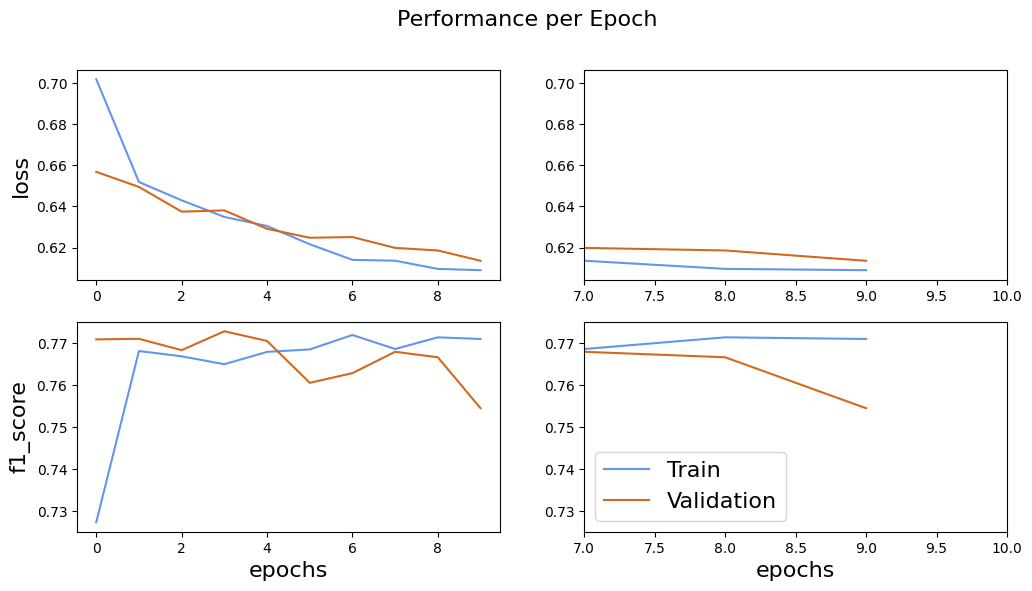

In [707]:
plot_history(history, 'f1_score', name='model_history', colors=COLORS)

Evaluating the model on training and validation data.

In [84]:
print(f'Train set evaluate: {model.evaluate(train_set, verbose=0)[1]:.4f}')
print(f'Validation set evaluate: {model.evaluate(val_set, verbose=0)[1]:.4f}')

Train set evaluate: 0.8046
Validation set evaluate: 0.7545


Evaluating the final model on the test set.

In [86]:
print(f'Test set evaluate: {model.evaluate(test_set, verbose=0)[1]:.4f}')

Test set evaluate: 0.7536


<a name="6"></a>
## Word Embeddings Visualization
After training the model, let's visualize the word embeddings that our model learned. Therefore, we extract the weights from the embedding layer to plot the embedding of each corresponding word. The embedding layer has only one matrix, which contains the embeddings. The plot was created by plotting `word_to_plot` word embeddings of some `idx` given example between the two classes. Where `word_to_plot` and `idx` are parameters of the function to plot word embeddings in 2 dimensions.

Generally, similar words tend to be grouped close to each other. Sometimes even antonyms tend to be grouped close to each other. Antonyms describe the same thing, but they tend to be on the other end of the scale. They are usually found in the same place in a sentence, have the same parts of speech, and therefore, when learning word embedding, we end up getting similar weights. However, sometimes similar words don't necessarily group together because we only train the model to analyze general sentiment.

We define two subsets, one for each class, that is, one with only positive examples (action class) and the second only with negative examples (non-action class). Then, we also define the colors for the plot. Remembering that the plotted words are initially pre-processed, that is, with stemming applied.

Concatenating all datasets to plot the word embeddings and plotting their dimension.

In [152]:
dataset = np.concatenate(datasets)
print(f'Dataset dimension: {dataset.shape}')

Dataset dimension: (16137, 167)


Selecting the corpus with only the `action` class and the corpus with only the `non-action` class, that is, the positive and negative class.

In [186]:
pos_corpus = dataset[dataset[:, -1] == 1][:, :-1]
neg_corpus = dataset[dataset[:, -1] == 0][:, :-1]
print(f'Positive corpus dimension: {pos_corpus.shape}')

Positive corpus dimension: (10122, 166)


Obtaining the embedding layer and its weights to plot the embedding of each corresponding word.

In [614]:
embedding_layer = model.get_layer('embedding_layer')
embeddings = embedding_layer.get_weights()[0]
print(f'The word embedding matrix have {len(embeddings)} words.')

The word embedding matrix have 1000 words.


As our embeddings are 32-dimensional (the dimension we defined for the word embeddings matrix), it is difficult to visualize them without some type of transformation. Therefore, we will use [scikit-learn](https://scikit-learn.org/stable/) to perform dimensionality reduction of word embeddings using [`Kernel PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) (using `2 main components`, `kernel='rbf'` and `gamma=0.9` as hyperparameters), with which you can reduce the number of dimensions to two while keeping as much information as possible.
* Kernel trick can be applied to PCA, making it possible to perform complex non-linear projections for dimensionality reduction. This is called `Kernel PCA (KPCA)`. As a rule, it is good at preserving clusters of examples after projection or, sometimes, even unrolling datasets close to a distorted manifold.
    * Kernel trick is a mathematical technique that implicitly maps examples into a high-dimensional space, called `feature space`, allowing classification and non-linear regression with SVMs. A linear decision boundary in the high-dimensional feature space corresponds to a complex non-linear decision boundary in the original space.

Therefore, now, after the dimensionality reduction where we transform our embeddings vectors from 32 dimensions to 2 dimensions we can create our 2D visualization. Plotting the word embeddings of the positive corpus and the negative corpus.

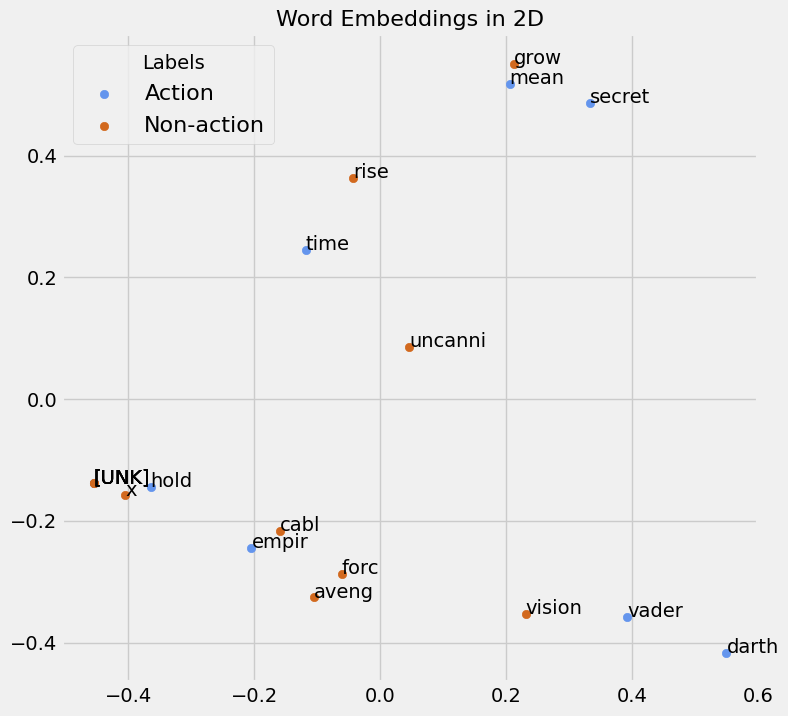

In [602]:
plot_word_embeddings(
    embeddings,
    pos_corpus,
    neg_corpus,
    VOCABULARY,
    idx=3,
    words_to_plot=10,
    name='word_embeddings_2d',
    colors=COLORS
)